In [1]:
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt
import os
from os.path import isfile
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import glob
%matplotlib inline

In [2]:
meshPath='/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc'
maskName='tmask'

In [3]:
j0=230;j1=470;i0=0;i1=200;
ct=240;cz=40;cy=50;cx=200;

In [4]:
def prepro(ds):
    return ds.loc[dict(y=slice(j0,j1),x=slice(i0,i1))]

In [5]:
mesh=xr.open_mfdataset(meshPath,chunks={'t':1, 'z':cz, 'y':cy, 'x':cx},preprocess=prepro,parallel=True)

In [6]:
mesh2=mesh.loc[{'z':0}]

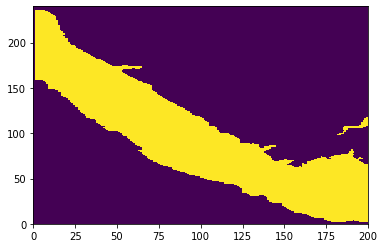

In [7]:
plt.pcolormesh(mesh2['tmask'].squeeze())

In [8]:
flistmuZ=et.index_model_files(dt.datetime(2015,6,1),dt.datetime(2015,9,1),
                             '/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/',
                             'long',10,'ptrc_T',1)

first file starts on  2015-05-31 00:00:00


In [9]:
flistHC=et.index_model_files(flistmuZ['t_0'][0],flistmuZ['t_n'][len(flistmuZ)-1]-dt.timedelta(days=1),
                             '/results/SalishSea/hindcast.201905/',
                             'nowcast',1,'ptrc_T',1)

Exception: 
File not found:
/results/SalishSea/hindcast.201905/31may15/SalishSea_1h_20150531_20150531_ptrc_T.nc
Check that results directory is accessible and the start date entered is included in the run. 


In [ ]:
t0=dt.datetime.now()
dataHC=xr.open_mfdataset(flistHC['paths'],data_vars=('diatoms','microzooplankton'),chunks={'time_counter':ct, 'deptht':cz, 'y':cy, 'x':cx},
            drop_variables=('nitrate','ammonium','silicon','flagellates','ciliates','dissolved_organic_nitrogen',
                            'particulate_organic_nitrogen','biogenic_silicon','mesozooplankton'),preprocess=prepro,parallel=True)
t1=dt.datetime.now()
print(t1-t0)

In [ ]:
dataHC

In [ ]:
t0=dt.datetime.now()
datamuZ=xr.open_mfdataset(flistmuZ['paths'],data_vars=('diatoms','microzooplankton'),chunks={'time_counter':ct, 'deptht':cz, 'y':cy, 'x':cx},
            drop_variables=('nitrate','ammonium','silicon','flagellates','ciliates','dissolved_organic_nitrogen',
                            'particulate_organic_nitrogen','biogenic_silicon','mesozooplankton'),preprocess=prepro,parallel=True)
t1=dt.datetime.now()
print(t1-t0)

In [ ]:
datamuZ=datamuZ.rename({'time_counter':'t','deptht':'z'})

In [ ]:
datamuZ

In [ ]:
import dask
from dask.distributed import Client, progress
import dask.array as da

In [ ]:
client = Client()
client

In [ ]:
tmask=da.asanyarray(mesh['tmask']).rechunk(('auto',-1,'auto','auto'))
e3t=da.asanyarray(mesh['e3t_0']).rechunk(('auto',-1,'auto','auto'))
diatomsmuZ=da.asanyarray(datamuZ['diatoms']).rechunk(('auto',cz,'auto','auto'))
diatomsHC=da.asanyarray(dataHC['diatoms']).rechunk(('auto',cz,'auto','auto'))

In [ ]:
tmask

In [ ]:
e3t

In [ ]:
diatomsmuZ

In [ ]:
prod1=tmask*e3t*diatomsmuZ

In [ ]:
prod1

In [ ]:
sum1=dask.array.sum(prod1,axis=1)

In [ ]:
sum1

In [ ]:
diatomsmuZInt=da.mean(sum1,0)

In [ ]:
prod2=tmask*e3t*diatomsHC
sum2=dask.array.sum(prod2,axis=1)
diatomsHCInt=da.mean(sum2,0)

In [ ]:
#diatomsmuZInt.visualize()

In [ ]:
t0=dt.datetime.now()
diatomsmuZInt=diatomsmuZInt.compute()
t1=dt.datetime.now()
print(t1-t0)

In [ ]:
t0=dt.datetime.now()
diatomsHCInt=diatomsHCInt.compute()
t1=dt.datetime.now()
print(t1-t0)

In [ ]:
t0=dt.datetime.now()
fig,ax=plt.subplots(1,3,figsize=(15,4))
m0=ax[0].pcolormesh(diatomsmuZInt)
plt.colorbar(m0,ax=ax[0])
ax[0].set_title('muZ Diatoms')
m1=ax[1].pcolormesh(diatomsHCInt)
plt.colorbar(m1,ax=ax[1])
ax[1].set_title('HC Diatoms')
m2=ax[2].pcolormesh(diatomsmuZInt-diatomsHCInt)
plt.colorbar(m2,ax=ax[2])
ax[2].set_title('Diff')
t1=dt.datetime.now()
print(t1-t0)